In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals, pool2graph_cat_FJ2_2

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# Get data and fit a pool of classifiers on it

X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult-cat')
print(X_train.shape, y_train.mean())
cont_names = list(set(feature_names) - set(cat_names))

taking only 1000 instances
(670, 28) 0.24029850746268658


In [11]:

pool1 = pool.BasicPool()
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_test)
from sklearn.metrics import f1_score
print({c: f1_score(y_test, preds[c]) for c in preds.columns})


p2g = pool2graph_cat_FJ2_2.pool2graph(X_train, y_train, pool1, k_init=3, categorical_names=cat_names)
#p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=3)

p2g.fit(max_epochs=4)
print(len(p2g.G.nodes))

{'SVMrbf': 0.3191489361702128, 'SVMsigmoid': 0.3958333333333333, 'RF50': 0.5285714285714287, 'RF100': 0.5, 'RF200': 0.5106382978723405, 'KNN5': 0.36764705882352944}


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4


4004


In [4]:
%load_ext autoreload

%autoreload 2
from discrepancies import discrepancies_intervals

In [12]:
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
print(len(intervals))

2104


# Global analysis of the intervals

In [46]:
%load_ext autoreload

%autoreload 2
from discrepancies import analysis_global


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
### we work with that    
df_amplitude = analysis_global.build_amplitude_dataset(intervals, cat_names)

In [6]:
analysis_global.categories_summary(df_amplitude, X_train, cat_names)

Representation in the training set
race_White                 0.838806
sex_Male                   0.646269
sex_Female                 0.353731
education_HS-grad          0.353731
education_Some-college     0.213433
education_Bachelors        0.143284
race_Black                 0.092537
education_Masters          0.056716
education_11th             0.038806
education_Assoc-voc        0.038806
race_Asian-Pac-Islander    0.037313
education_Assoc-acdm       0.035821
education_10th             0.032836
education_7th-8th          0.020896
education_12th             0.016418
race_Amer-Indian-Eskimo    0.016418
education_Prof-school      0.014925
education_9th              0.014925
race_Other                 0.014925
education_Doctorate        0.010448
education_1st-4th          0.005970
education_5th-6th          0.002985
education_Preschool        0.000000
dtype: float64
Representation in Amplitude dataset
sex_Male                   0.898949
race_White                 0.831916
education_HS-g

Overrepresentation of sex_Male=1 in the intervals: how to interpret it?

### How big is the discrepancy detected?

In [ ]:
# TODO

### Most problematic features

For now, we evaluate separately the uncertainty associated to each feature for continuous and categorical features.
- For continuous features: Average range of the discrepancy interval along the feature
- For categorical features: proportion of intervals generated along the feature, normalized by the exposition in Xtrain --> to rework

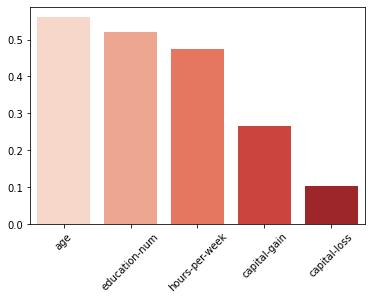

Text(0.5, 1.0, 'Categorical features')

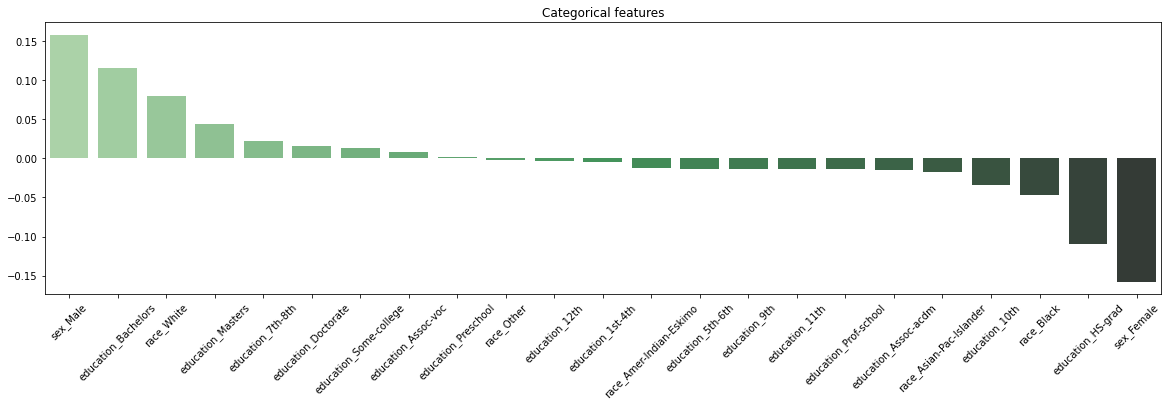

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

featimp = analysis_global.get_global_discrepancy_importances(df_amplitude, X_train, cat_names)

plt.xticks(rotation=45)
sns.barplot(data=pd.DataFrame(featimp['continous_features']).T, palette="Reds")
plt.show()
plt.figure(figsize=(20,5))
plt.xticks(rotation=45)
sns.barplot(data=pd.DataFrame(featimp['categorical_features']).T, palette="Greens_d")
plt.title("Categorical features")


## Important areas of discrepancy

We try to identify important discrepancy areas
- Second approach: Segment / cluster nodes
- First: ignore for now.

(df_amplitude['sex_Male']==1)
1758
4.971727010879509


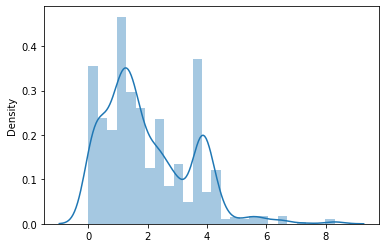

(df_amplitude['sex_Male']==0)
346
4.687281793725772


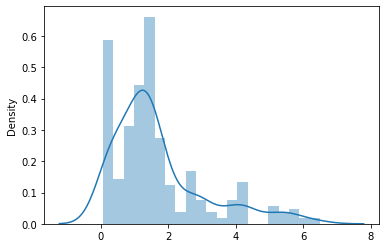

(df_amplitude['sex_Male']==1)&(df_amplitude['race_White']==1)
1664
4.973953574589866


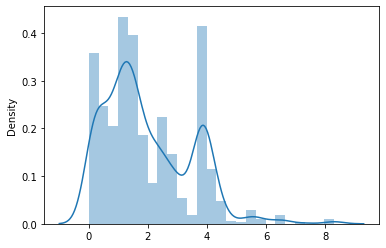

(df_amplitude['sex_Male']==1)&(df_amplitude['race_White']==1)&(df_amplitude['education_Bachelors']==1)
463
4.915828477403559


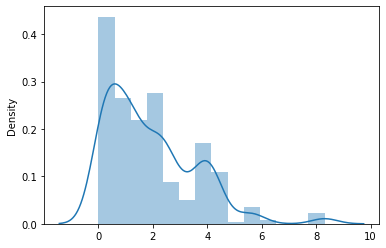

(df_amplitude['sex_Male']==1)&(df_amplitude['race_White']==1)&(df_amplitude['education_Bachelors']==0)
1201
4.99636150131531


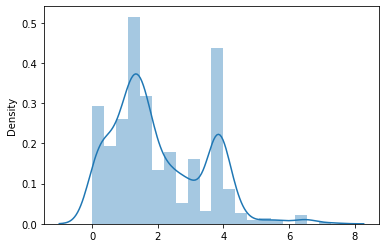

In [120]:
### évaluer la gravité moyenne des intervalles d'un segment

combinations = [{'sex_Male':1},
                {'sex_Male':0},
                {'sex_Male':1, 'race_White':1},
                {'sex_Male':1, 'race_White':1, 'education_Bachelors':1},
                {'sex_Male':1, 'race_White':1, 'education_Bachelors':0},
]

for c in combinations:
    conditions_list = "&".join(["(df_amplitude['{0}']=={1})".format(col, cond) for col, cond in c.items()])
    segment = df_amplitude[eval(conditions_list)]
    exposition_intervals = segment.shape[0]
    discrepancy_total_size = segment[cont_names].sum(axis=0)
    discrepancy_average_size = segment[cont_names].mean(axis=0)
    print(conditions_list)
    print(exposition_intervals)
    print(analysis_global.interval_uncertainty(segment, cont_names, metric='sum'))
    
    sns.distplot(segment[cont_names].sum(axis=1))
    plt.show()
    

#### Segmenting discrepancy areas with a tree

accuracy 1.0


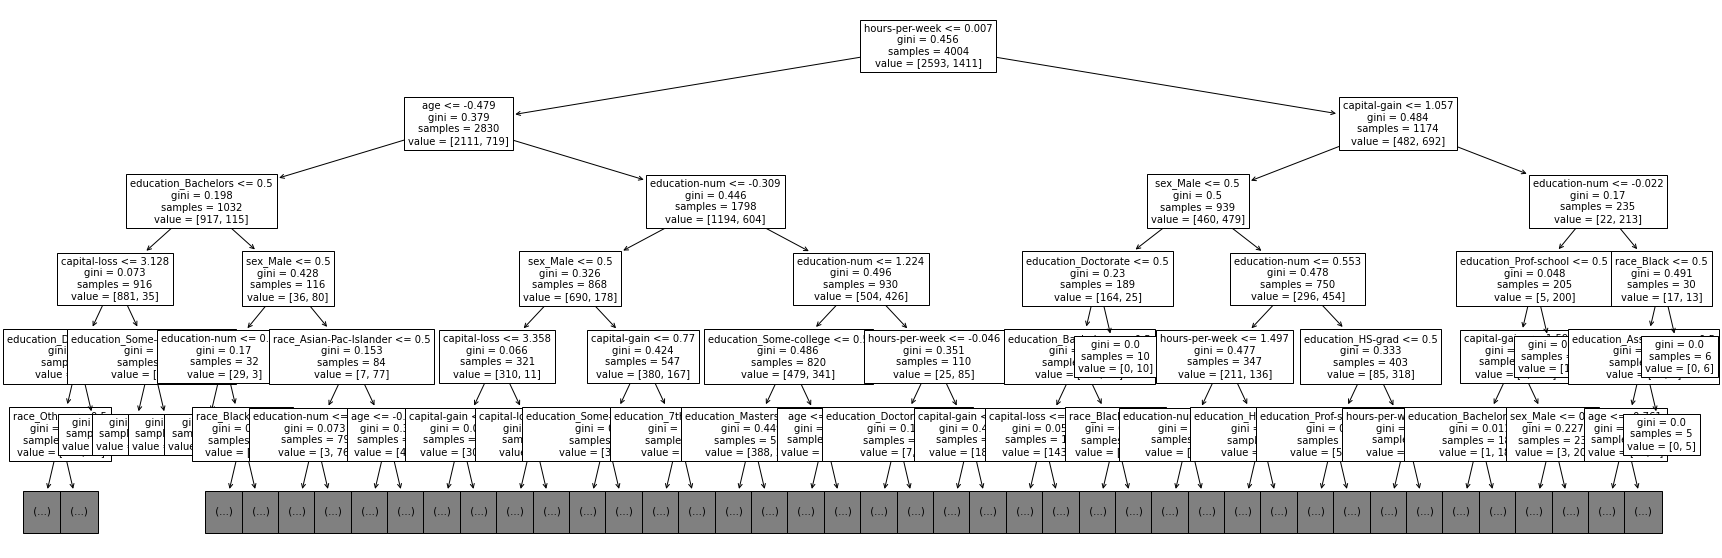

In [139]:
disc_nodes = [n[1]['features'] for n in p2g.G.nodes(data=True) if n[1]['discrepancies'] >= 0]
discs = np.array([n[1]['discrepancies'] for n in p2g.G.nodes(data=True) if n[1]['discrepancies'] >= 0])
df_nodes = pd.DataFrame(disc_nodes)#[cat_names]
df_nodes[cat_names] = (df_nodes[cat_names] > 0).astype('int')



from sklearn.tree import DecisionTreeClassifier, plot_tree


dt = DecisionTreeClassifier(max_depth=None, min_samples_split=2)
dt.fit(df_nodes, discs)
print('accuracy', dt.score(df_nodes, discs))


plt.figure(figsize =(30,10))
plot_tree(dt, fontsize=10, feature_names = df_nodes.columns, max_depth=5)
plt.show()

Ex: There is an "important" discrepancy area ( in terms of nodes, n=205) characterized by:
- hours/week >0.007
- capital-gain>1.057
- edcuation-Num <= -0.022


In [142]:
# Associated exposition in Xtrain:
X_train[(X_train['hours-per-week'] > 0.007)&(X_train['capital-gain'] > 1.057)&(X_train['education-num'] <= -0.022)].shape
# "good"(?) example of an area with low exposition in the original Xtrain set that was discovered afterwards.



(2, 28)

<AxesSubplot:xlabel='capital-gain', ylabel='Density'>

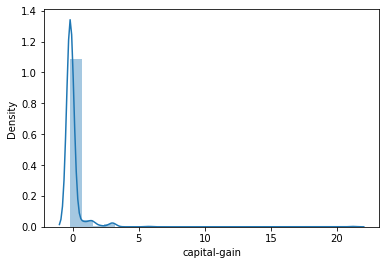

In [149]:
sns.distplot(X_train['capital-gain'])

(670, 28)